In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 94.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 87.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 39.3 MB/s eta 0:00:00


In [1]:
import transformers
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration
import nltk
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# from google.colab import drive

# drive.mount("/content/drive", force_remount=True)

In [2]:
data = pd.read_csv("/content/dataset_train_final (1).csv")

In [3]:
data

,Unnamed: 0,image_name,text_ocr,overall_sentiment,Image_Representation
0,0,image_4499,I once had a Lizard and a Fish as pets..,positive,The image features a man with a beard and must...
1,1,image_3937,GOES TO SCHOOL WITH 15 POGS COMES HOME WITH 100,negative,"The image features a young man sitting down, w..."
2,2,image_5060,MERICA wo FRENCH FRY HOLDER FUCK YEAH imgflip.com,positive,The image features a person holding a French f...
3,3,image_1380,3x02 GAANOTHSCENES You know what's weird. Dona...,positive,The image features a man wearing a suit and bo...
4,4,image_3871,@NFL_MEMES EACH SPORT HAS IT'S GREATEST BUT HE...,neutral,The image is a collage of various sports momen...
...,...,...,...,...,...
695,695,image_3259,"There's no such thing as ""ex-KGB""! You can tak...",negative,The image features a man wearing a suit and ti...
696,696,image_1159,When your grandma gets drunk,positive,The image features a collection of broken and ...
697,697,image_6041,When your entire social media timeline is one ...,positive,The image features a man with a smiling expres...
698,698,image_6076,Fuck the 10 year challenge who's brave enough ...,positive,The image is a black and white meme featuring ...


In [7]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.2 MB/s eta 0:00:00


In [14]:
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [17]:
train_data = data["Image_Representation"].to_list()
train_data_label = data["overall_sentiment"].to_list()

In [18]:
input_encoding = tokenizer(train_data,max_length=9000,padding=True,truncation=True,return_tensors ="pt")
label_encoding = tokenizer(train_data_label,max_length=1024,padding=True,truncation=True,return_tensors ="pt")

In [19]:
from transformers import AutoModelForSeq2SeqLM,DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

In [20]:
train_dataset = [{"input_ids": input_encoding["input_ids"][i], "attention_mask": input_encoding["attention_mask"][i],
                  "labels": label_encoding["input_ids"][i]} for i in range(len(data))]

In [ ]:
# test_data_ = test_data["INPUT"].to_list()
# test_data_label = test_data["OUTPUT"].to_list()

In [ ]:
# test_input_encoding = tokenizer(test_data_,padding=True,truncation=True,return_tensors ="pt")
# test_label_encoding = tokenizer(test_data_label,padding=True,truncation=True,return_tensors ="pt")

In [ ]:
# eval_dataset = [{"input_ids": test_input_encoding["input_ids"][i], "attention_mask": test_input_encoding["attention_mask"][i],
#                   "labels": test_label_encoding["input_ids"][i]} for i in range(len(test_data))]

In [ ]:
# import wandb
# wandb.init(project="ATG", config={"learning_rate": 1e-4, "batch_size": 32})

In [21]:
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    padding=True,
    label_pad_token_id=tokenizer.pad_token_id)

In [10]:
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 4.4 MB/s eta 0:00:00


In [30]:
training_args = Seq2SeqTrainingArguments(
        output_dir="large_model",
        logging_dir="./logs",
        logging_strategy = 'steps',
        logging_first_step = "True",
        logging_steps = 1,
        overwrite_output_dir=True,
        per_device_train_batch_size=8,
        num_train_epochs=20,
        save_steps=1000,
        eval_steps=1000,
        save_total_limit=2,
        report_to="none",
        learning_rate=1e-4)

In [31]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
#     init_logging=init_logging,
    # eval_dataset = eval_dataset
)

In [32]:
trainer.create_optimizer()
trainer.create_scheduler(16)

In [ ]:
# from transformers import TrainingArguments, Trainer

# args = TrainingArguments(... , report_to="wandb")
# trainer = Trainer(... , args=args)

In [ ]:
# import os
# os.environ["WANDB_DISABLED"] = "True"
# if os.getenv("WANDB_DISABLED"):
#     print("Disabled")

In [33]:
trainer.train()

OutOfMemoryError: ignored

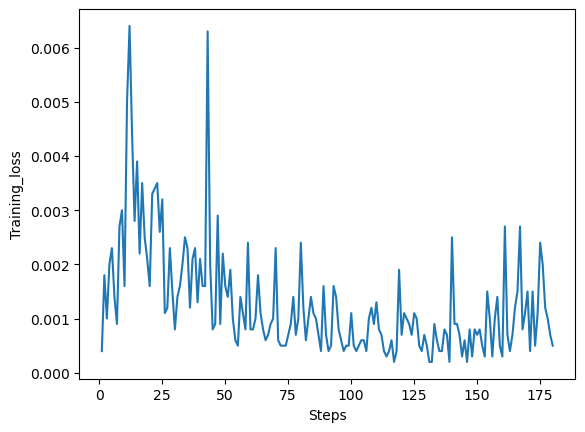

In [ ]:
loss = []
step = []
for i in trainer.state.log_history:
#     loss.append(i['loss'])
#     step.append(i['step'])
    if "loss" in i.keys():
        loss.append(i['loss'])
        step.append(i['step'])

l = np.array(loss)
s = np.array(step)
plt.plot(s,l)
plt.xlabel("Steps")
plt.ylabel("Training_loss")
plt.show()

In [ ]:
trainer.state.log_history

[{'loss': 32.3636,
  'learning_rate': 9.962962962962963e-05,
  'epoch': 0.11,
  'step': 1},
 {'loss': 27.606,
  'learning_rate': 9.925925925925926e-05,
  'epoch': 0.22,
  'step': 2},
 {'loss': 25.3223,
  'learning_rate': 9.888888888888889e-05,
  'epoch': 0.33,
  'step': 3},
 {'loss': 22.6677,
  'learning_rate': 9.851851851851852e-05,
  'epoch': 0.44,
  'step': 4},
 {'loss': 22.9211,
  'learning_rate': 9.814814814814815e-05,
  'epoch': 0.56,
  'step': 5},
 {'loss': 20.4714,
  'learning_rate': 9.777777777777778e-05,
  'epoch': 0.67,
  'step': 6},
 {'loss': 19.8486,
  'learning_rate': 9.740740740740741e-05,
  'epoch': 0.78,
  'step': 7},
 {'loss': 19.0524,
  'learning_rate': 9.703703703703704e-05,
  'epoch': 0.89,
  'step': 8},
 {'loss': 18.7203,
  'learning_rate': 9.666666666666667e-05,
  'epoch': 1.0,
  'step': 9},
 {'loss': 16.815,
  'learning_rate': 9.62962962962963e-05,
  'epoch': 1.11,
  'step': 10},
 {'loss': 16.1192,
  'learning_rate': 9.592592592592593e-05,
  'epoch': 1.22,
  'st

In [ ]:
trainer.save_model("large_model")

In [ ]:
m = T5ForConditionalGeneration.from_pretrained("model")
# trainer.compute_loss(m,train_dataset)

In [ ]:
t = tokenizer
m = T5ForConditionalGeneration.from_pretrained("large_model")

In [ ]:
check = ["Channel 2 requires 12 volts"]
c = t(check,truncation=True,return_tensors="pt")
o = m.generate(**c,max_length=1024)
# o = trainer.predict(**c,max_length=1024)
decode_output = t.batch_decode(o,skip_special_tokens=True)
print(decode_output)
# predicted = nltk.sent_tokenize(decode_output)[0]

['set_voltage[ds]12']


In [ ]:
trainer.save_model()

### Text to SQL setup

In [ ]:
import pandas as pd
import numpy as np
import torch
import shutil
import os
import random
# import evaluate
# evaluate.logging.disable_progress_bar()

from random import sample
from transformers import  AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from datasets import load_dataset, Dataset, concatenate_datasets

In [ ]:
from datasets import load_dataset

import pandas as pd
from datasets import Dataset

# Load the XLSX file using pandas
df = pd.read_excel("T2S_180.xlsx")

In [ ]:
df

In [ ]:
CKPT= "juierror/text-to-sql-with-table-schema"
# CKPT = "google/flan-t5-large"
from transformers import AutoTokenizer, T5ForConditionalGeneration
tokenizer = AutoTokenizer.from_pretrained(CKPT)
model = T5ForConditionalGeneration.from_pretrained(CKPT)

In [ ]:
df_train = df[0:178]
df_test = df[140:150]

In [ ]:
df_train

In [ ]:
train_data = df_train["Text"].to_list()
train_data_label = df_train["Query"].to_list()

In [ ]:
input_encoding = tokenizer(train_data,max_length=200,padding=True,truncation=True,return_tensors ="pt")
label_encoding = tokenizer(train_data_label,max_length=1000,padding=True,truncation=True,return_tensors ="pt")

In [ ]:
label_encoding

In [ ]:
from transformers import AutoModelForSeq2SeqLM,DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

In [ ]:
train_dataset = [{"input_ids": input_encoding["input_ids"][i], "attention_mask": input_encoding["attention_mask"][i],
 "labels": label_encoding["input_ids"][i]} for i in range(len(df_train))]

In [ ]:
test_data= df_test["Text"].to_list()
test_data_label = df_test["Query"].to_list()

In [ ]:
test_input_encoding = tokenizer(test_data,padding=True,truncation=True,return_tensors ="pt")
test_label_encoding = tokenizer(test_data_label,padding=True,truncation=True,return_tensors ="pt")

In [ ]:
eval_dataset = [{"input_ids": test_input_encoding["input_ids"][i], "attention_mask": test_input_encoding["attention_mask"][i],
                  "labels": test_label_encoding["input_ids"][i]} for i in range(len(test_data))]

In [ ]:
train_dataset[0]

In [ ]:
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    padding=True,
    label_pad_token_id=tokenizer.pad_token_id)

In [ ]:
# set training arguments - Feel free to adapt it
training_args = Seq2SeqTrainingArguments(
    output_dir="Text2SQL_Model",
    per_device_train_batch_size=16,
    num_train_epochs= 1,
    per_device_eval_batch_size=16,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    do_train=True,
    do_eval=True,
    logging_steps=500,
    save_strategy="epoch",
    #save_steps=1000,
    #eval_steps=1000,
    overwrite_output_dir=True,
    save_total_limit=3,
    load_best_model_at_end=True,
#     push_to_hub=True,
    learning_rate=1e-4
    #fp16=True,
)

In [ ]:
# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator = data_collator,
    train_dataset=train_dataset,
    eval_dataset= eval_dataset
)



